In [1]:
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import mannwhitneyu

# from enlight.plotting.colors import eval_setting_map, subset_map

In [2]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "within condition": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}


In [3]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True

In [4]:
base_fig_dir = "/path/to/Figures/monge/"

In [5]:
with open("/path/to/CAR_variants.txt", "r") as f:
    cars = f.read().splitlines()

base_log_dir = "/path/to/experiments/monge/FuncScore/logs/"
experiment_order = ["CAROT", "identity", "within condition"]

In [6]:
all_mean_stats = []
for subset in ["CD4", "CD8"]:
    for car in cars:
        if car in ["NA-NA-z", "NA-NA-NA"]:
            continue
        with open(f"{base_log_dir}{subset}__NA-NA-NA_{car}_logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        print(subset, car, len(logs["experiments"]))
        for i, exp in enumerate(logs["experiments"]):
            mean_stats = pd.DataFrame.from_dict(logs["experiments"][i]["mean_statistics"], orient="index")
            mean_stats['CAR'] = car
            mean_stats["setting"] = experiment_order[i]
            mean_stats["subset"] = subset

            all_mean_stats.append(mean_stats)

CD4 41BB-41BB-z 3
CD4 41BB-CD28-z 3
CD4 41BB-CD40-z 3
CD4 41BB-CTLA4-z 3
CD4 41BB-IL15RA-z 3
CD4 41BB-NA-z 3
CD4 CD28-41BB-z 3
CD4 CD28-CD28-z 3
CD4 CD28-CD40-z 3
CD4 CD28-CTLA4-z 3
CD4 CD28-IL15RA-z 3
CD4 CD28-NA-z 3
CD4 CD40-41BB-z 3
CD4 CD40-CD28-z 3
CD4 CD40-CD40-z 3
CD4 CD40-CTLA4-z 3
CD4 CD40-IL15RA-z 3
CD4 CD40-NA-z 3
CD4 CTLA4-41BB-z 3
CD4 CTLA4-CD28-z 3
CD4 CTLA4-CD40-z 3
CD4 CTLA4-CTLA4-z 3
CD4 CTLA4-IL15RA-z 3
CD4 CTLA4-NA-z 3
CD4 IL15RA-41BB-z 3
CD4 IL15RA-CD28-z 3
CD4 IL15RA-CD40-z 3
CD4 IL15RA-CTLA4-z 3
CD4 IL15RA-IL15RA-z 3
CD4 IL15RA-NA-z 3
CD8 41BB-41BB-z 3
CD8 41BB-CD28-z 3
CD8 41BB-CD40-z 3
CD8 41BB-CTLA4-z 3
CD8 41BB-IL15RA-z 3
CD8 41BB-NA-z 3
CD8 CD28-41BB-z 3
CD8 CD28-CD28-z 3
CD8 CD28-CD40-z 3
CD8 CD28-CTLA4-z 3
CD8 CD28-IL15RA-z 3
CD8 CD28-NA-z 3
CD8 CD40-41BB-z 3
CD8 CD40-CD28-z 3
CD8 CD40-CD40-z 3
CD8 CD40-CTLA4-z 3
CD8 CD40-IL15RA-z 3
CD8 CD40-NA-z 3
CD8 CTLA4-41BB-z 3
CD8 CTLA4-CD28-z 3
CD8 CTLA4-CD40-z 3
CD8 CTLA4-CTLA4-z 3
CD8 CTLA4-IL15RA-z 3
CD8 CTLA4-NA

In [7]:
res = pd.concat(all_mean_stats).reset_index().rename(columns={"index": "metric", 0:"score"})
res

,metric,score,CAR,setting,subset
0,mean_wasserstein,5.668510,41BB-41BB-z,CAROT,CD4
1,mean_mmd,0.024757,41BB-41BB-z,CAROT,CD4
2,mean_sinkhorn div,5.192612,41BB-41BB-z,CAROT,CD4
3,mean_monge_gap,11.405769,41BB-41BB-z,CAROT,CD4
4,mean_drug_signature,0.731012,41BB-41BB-z,CAROT,CD4
...,...,...,...,...,...
1075,mean_mmd,0.012517,IL15RA-NA-z,within condition,CD8
1076,mean_sinkhorn div,5.679140,IL15RA-NA-z,within condition,CD8
1077,mean_monge_gap,12.339099,IL15RA-NA-z,within condition,CD8
1078,mean_drug_signature,0.805206,IL15RA-NA-z,within condition,CD8


In [8]:
pvals = []
metrics = []
subsets = []
comparisons = []
for metric in ["mean_mmd", "mean_r2"]:
    for subset in ["CD8", "CD4"]:
        for comparison in [("CAROT", "identity"), ("CAROT", "within condition")]:
            sel_res = res[(res["metric"]==metric)&(res["subset"]==subset)]

            pval = mannwhitneyu(sel_res.loc[sel_res["setting"]==comparison[0], "score"], 
                                sel_res.loc[sel_res["setting"]==comparison[1], 'score'],
                                ).pvalue 
            pvals.append(pval)
            metrics.append(metric)
            subsets.append(subset)
            comparisons.append(comparison)
stats = pd.DataFrame({"pval": pvals, "subset": subsets, "metric": metrics})
stats[["setting1", "setting2"]] = comparisons
stats["corr_pval"] = stats["pval"] *len(stats)
stats["treshold"] = 0.05/len(stats)
stats["significant1"] =  stats["pval"] < stats["treshold"]
stats["significant2"] =  stats["corr_pval"] < 0.05
stats

,pval,subset,metric,setting1,setting2,corr_pval,treshold,significant1,significant2
0,1.070179e-09,CD8,mean_mmd,CAROT,identity,8.561429e-09,0.00625,True,True
1,1.584609e-04,CD8,mean_mmd,CAROT,within condition,1.267688e-03,0.00625,True,True
2,1.156654e-07,CD4,mean_mmd,CAROT,identity,9.253235e-07,0.00625,True,True
3,1.891619e-04,CD4,mean_mmd,CAROT,within condition,1.513295e-03,0.00625,True,True
4,3.019859e-11,CD8,mean_r2,CAROT,identity,2.415887e-10,0.00625,True,True
5,1.334541e-01,CD8,mean_r2,CAROT,within condition,1.067633e+00,0.00625,False,False
6,3.019859e-11,CD4,mean_r2,CAROT,identity,2.415887e-10,0.00625,True,True
7,9.234421e-01,CD4,mean_r2,CAROT,within condition,7.387537e+00,0.00625,False,False


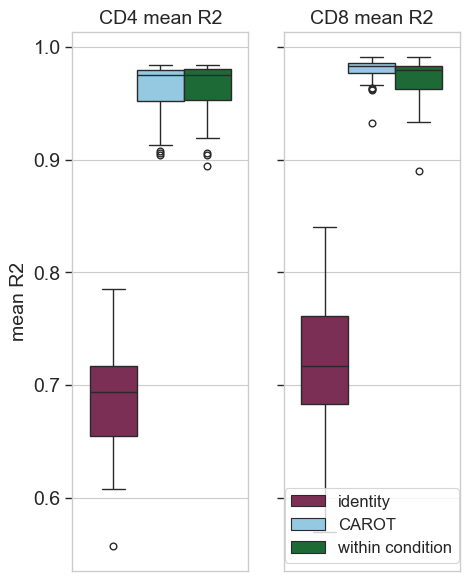

In [9]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "CAROT", "within condition"])
    axes[i].set_title(f"{subset} mean R2", fontsize=14)
    axes[i].set_ylabel("mean R2", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
plt.tick_params(which="both", axis="both", labelsize=14)
plt.savefig(f"{base_fig_dir}R2_performance.pdf", bbox_inches="tight")

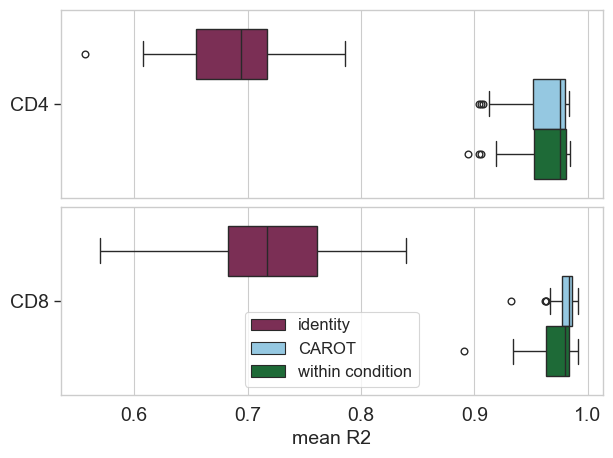

In [10]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_r2")]
    plt_data = plt_data.rename(columns={"setting": ""})
    sns.boxplot(data=plt_data, x="score", hue="", y="subset", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "CAROT", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[0].get_legend().remove()
axes[1].legend(fontsize=12, loc="lower center")
axes[1].set_xlabel("mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}R2_performance_horizontal.pdf", bbox_inches="tight")

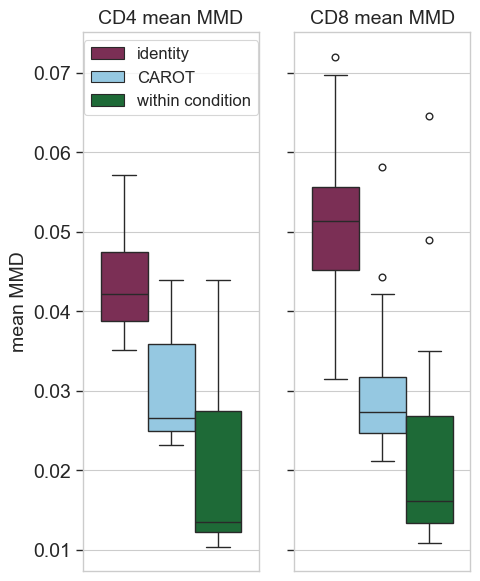

In [11]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5,7))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"setting": ""})
    sns.boxplot(data=plt_data, y="score", hue="", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "CAROT", "within condition"])
    axes[i].set_title(f"{subset} mean MMD", fontsize=14)
    axes[i].set_ylabel("mean MMD", fontsize=14)
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
plt.savefig(f"{base_fig_dir}MMD_performance.pdf", bbox_inches="tight")

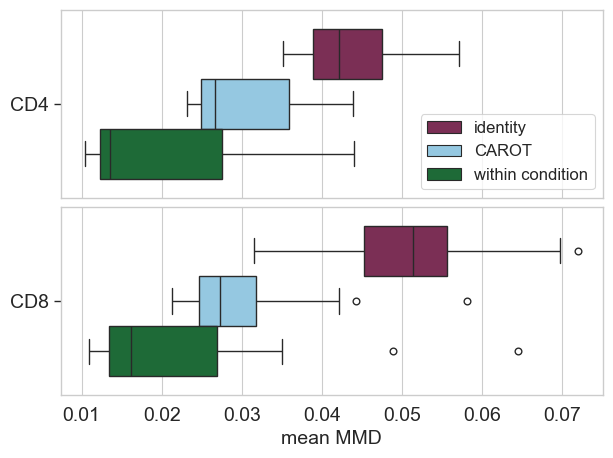

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7,5))
for i, subset in enumerate(["CD4", "CD8"]):
    plt_data = res[(res["subset"]==subset)&(res["metric"]=="mean_mmd")]
    plt_data = plt_data.rename(columns={"setting": ""})
    sns.boxplot(data=plt_data, x="score", hue="", y="subset", ax=axes[i], palette=eval_setting_map,
               hue_order=["identity", "CAROT", "within condition"])
    axes[i].set_ylabel("")
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="lower right")
axes[1].set_xlabel("mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.subplots_adjust(wspace=None, hspace=0.05)
plt.savefig(f"{base_fig_dir}MMD_performance_horizontal.pdf", bbox_inches="tight")

# Performance per CAR

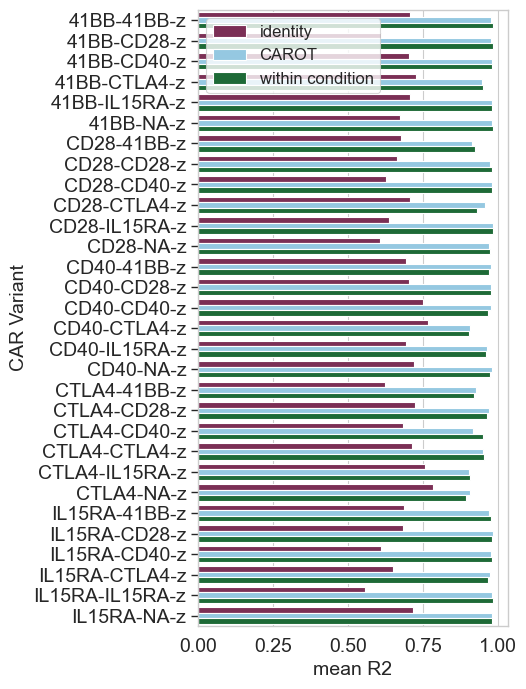

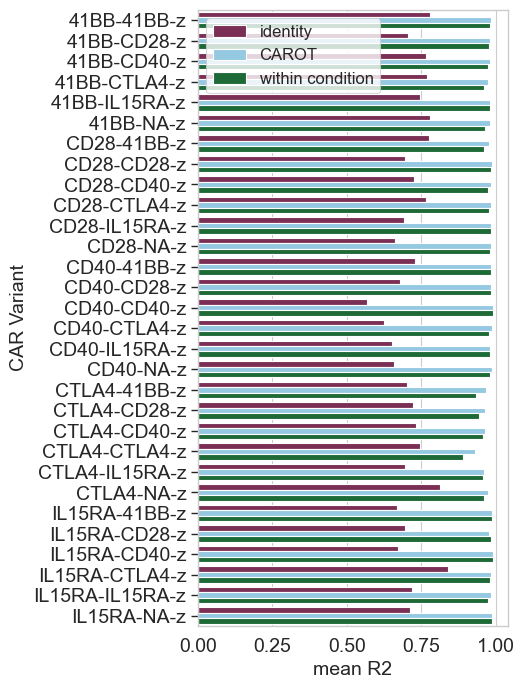

In [13]:
for subset in ["CD4", "CD8"]:
    plt_data = res[(res["metric"]=="mean_r2")&(res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="CAR", hue="setting", palette=eval_setting_map, 
                hue_order=["identity", "CAROT", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean R2", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}R2_performance_{subset}_all_cars.pdf", bbox_inches="tight")
    plt.show()

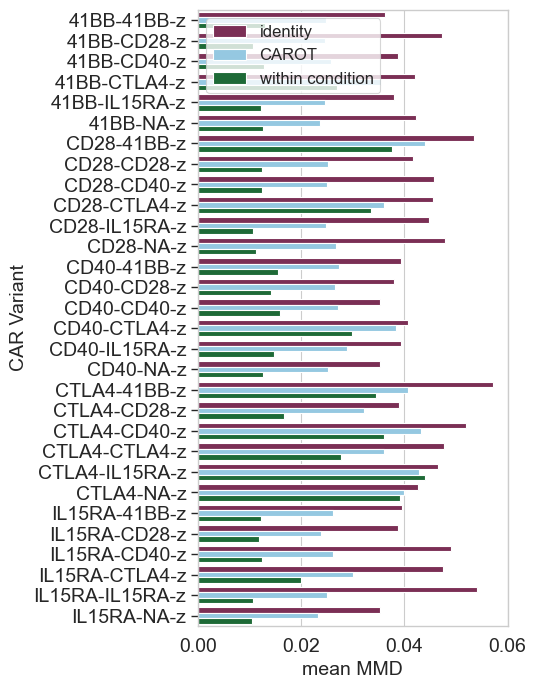

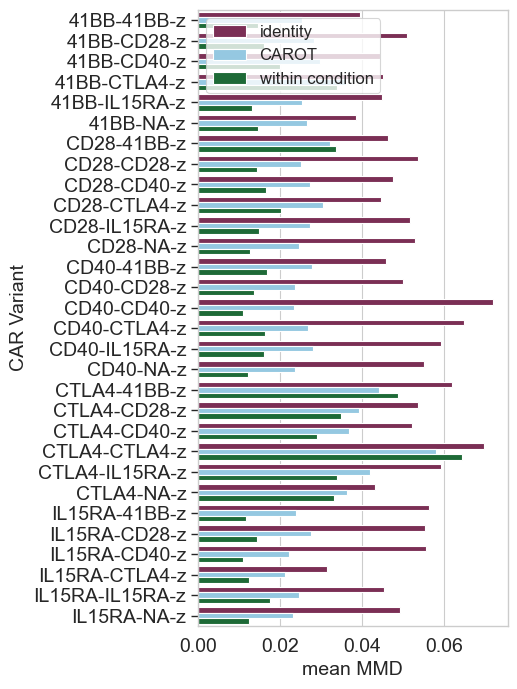

In [14]:
for subset in ["CD4", "CD8"]:
    plt_data = res[(res["metric"]=="mean_mmd")&(res["subset"]==subset)]
    plt.figure(figsize=(4,8))
    sns.barplot(data=plt_data, x="score", y="CAR", hue="setting", palette=eval_setting_map, 
                hue_order=["identity", "CAROT", "within condition"])
    plt.ylabel("CAR Variant", fontsize=14)
    plt.xlabel("mean MMD", fontsize=14)
    plt.tick_params(which="both", axis="both", labelsize=14)
    plt.legend(loc="upper left", title="", fontsize=12)
    plt.savefig(f"{base_fig_dir}MMD_performance_{subset}_all_cars.pdf", bbox_inches="tight")
    plt.show()